In [29]:
# standard libraries 
# networkx = 2.7
# cdt = 
# scipy = 1.8
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#from tueplots import axes, bundles , figsizes, fonts,fontsizes
#import seaborn as sns
import random 
from random import randrange
import time

In [30]:
# causal discovery
import networkx as nx
import cdt 
from cdt import SETTINGS
from cdt.independence.graph import FSGNN
from cdt.causality.pairwise import GNN
from cdt.utils.graph import dagify_min_edge
from cdt.causality.graph import CGNN

# read in data 

In [31]:
nsw = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/NswLalonde_transformed.csv') # RCT
nswre74 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/NswDeWab_transformed.csv') # RCT 
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv') # Quasi data 
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv') # Quasi data 
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv') # Quasi data 
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv') # Quasi data 

<p> organise data </p>

In [32]:
nswCps_lalonde.columns

Index(['treat', 'age', 'black', 'hispanic', 'married', 'nodegree', 're75',
       're78', 'education*', 'u75', 'educ_re75', 'hisp_u75', 'black_u75',
       'married_u75', 'nodegree_re75', 'nodegree_u75', 'nodegree_education',
       'black_age', 'black_education', 'hisp_re75', 'agesq', 're78sq',
       're75sq', 'educsq', 'ageboxcox', 're78boxcox', 're75boxcox', 'lnre78',
       'lnre75', 'education_1', 'education_2', 'education_3', 'education_4',
       'education_5', 'education_6', 'education_7', 'education_8',
       'education_9', 'education_10', 'education_11', 'education_12',
       'education_13', 'education_14', 'education_15', 'education_16',
       'education_17', 'education_18'],
      dtype='object')

In [33]:
dataset_baseline_1 = nsw
dataset_baseline_2 = nswre74

# quasi experimental datasets 
dataset1 = nswCps_lalonde
dataset2 = nswPsid_lalonde
dataset3 = nswCps_dehWab
dataset4 = nswPsid_dehWab

dataset_subset_0_lalonde_spec = ['treat','age','education*','black','married','nodegree','hispanic','re75']
dataset_subset_1_lalonde_spec = ['treat','age','education*','black','married','nodegree','hispanic','re75','re74']
dataset_subset1  = ['treat','ageboxcox', 'education*', 'black', 'hispanic', 'married', 'nodegree','lnre75',]
dataset_subset2  = ['treat','age', 'education*', 'black', 'hispanic', 'married', 'nodegree', 're74','re75']
features  = ['age', 'education*', 'black', 'hispanic', 'married', 'nodegree', 're75']
target = "treat"

<p> KEY </p>
<p> 0 = lalonde nsw rct </p>
<p> 1 = nsw treated + CPS control  (Lalonde's original sample) </p>
<p> 2 = nsw treated + PSID control (Lalonde's original sample) </p>
<p> 3 = nsw treated + CPS control  (Dehejia & Wahba sub-sample) </p>
<p> 4 = nsw treated + PSID control (Dehejia & Wahba sub-sample) </p>

In [34]:
# Key variables needed for DAGs
# 1 = individual/unit 
# 2 = outcome variable = wage in 1978 
# 3 = intervention/treatment variable  = treat column

In [35]:
from cdt.metrics import (precision_recall, SID, SHD)

# Representation learning

# 1 - nsw cps lalonde

<p> Feature selection model learn skeleton  </p>

In [36]:
epoc_train1 = 50
epoc_test1 = 25
epoc_train2 = 5
epoc_test2 = 5
runs = 5

Fsgnn = FSGNN(train_epochs=epoc_train1, test_epochs=epoc_test1, l1=0.1, batch_size=1000)

In [42]:
epoc_train2 = 3
epoc_test2 = 3

In [37]:
# 1 .  Create a skeleton graph  1 
# 0. Create FSGNN object
# train 50 epochs + test 25 = 75 - 80 minuites
# train 10 epoch + test 5 epoch = 15 minutes
start_time = time.time()
ugraph1 = Fsgnn.predict(dataset1[dataset_subset_0_lalonde_spec], threshold=1e-7)
print("--- Execution time (skeleton) : %4.4s seconds ---" % (time.time() - start_time))

# plot skeleton graph
#nx.draw_networkx(ugraph, font_size=8) # The plot function allows for quick visualization of the graph.
#plt.show()
#pd.DataFrame(list(ugraph.edges(data='weight')))

# A Logg of training times on my CPU 
# nruns : 3 + train : 3  + test : 3 +  10 covs = 17 mins


--- Execution time (skeleton) : 4772 seconds ---


<p> Generate Pairwise causal inference model  </p>

In [43]:
#2 . Generate Pairwise causal inference model 
start_time = time.time()
gnn = GNN(nruns=runs, train_epochs= epoc_train2, test_epochs=epoc_test2, batch_size=1000)
ograph1 = dagify_min_edge(gnn.orient_graph(dataset1[dataset_subset_0_lalonde_spec], ugraph1)) 
print("--- Execution time (pairwise): %4.4s seconds ---" % (time.time() - start_time))
# nruns : 5 + train : 3 epochs +  test : 3 = 75 minuites
# nruns : 5 + train : 10  + test : 5  = 23 minutes 
# nruns : 3 + train : 3  + test : 3 +  10 covs = 35 mins

KeyboardInterrupt: 

<p> CGNN - orient undirected pairwise graph with causal generative neural netowrk  </p>

In [ ]:
# 3.  Run causal GNN
start_time = time.time()
Cgnn = CGNN(nruns=runs, train_epochs=epoc_train2 , test_epochs=epoc_test2, batch_size=1000)
dgraph1 = Cgnn.orient_directed_graph(dataset1[dataset_subset_0_lalonde_spec], ograph1)
print("--- Execution time (cgnn): %4.4s seconds ---" % (time.time() - start_time))

# nruns : 5 + train : 3 epochs +  test : 3 = 75 minuites
# nruns : 5 + train : 10  + test : 5  = 38 minutes 
# nruns : 3 + train : 3  + test : 3 +  10 covs = 38  
# nruns : 3 + train : 3  + test : 3 +  10 covs = 16 minutes

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


--- Execution time (cgnn): 465. seconds ---


adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


# 2 - nsw PSID lalonde

<p> Feature selection model learn skeleton  </p>

In [ ]:
# 1 .  Create a skeleton graph  1 
# 0. Create FSGNN object
# train 50 epochs + test 25 = 75 minuites
# train 10 epoch + test 5 epoch = 15 minutes

start_time = time.time()
ugraph2 = Fsgnn.predict(dataset2[dataset_subset_0_lalonde_spec], threshold=1e-7)
print("--- Execution time (skeleton) : %4.4s seconds ---" % (time.time() - start_time))

# A Logg of training times on my CPU 
# nruns : 3 + train : 3  + test : 3 +  10 covs = 17 mins

--- Execution time (skeleton) : 122. seconds ---


<p> Generate Pairwise causal inference model  </p>

In [ ]:
#2 . Generate Pairwise causal inference model 
start_time = time.time()
gnn = GNN(nruns=runs, train_epochs=epoc_train2, test_epochs=epoc_test2, batch_size=1000)
ograph2 = dagify_min_edge(gnn.orient_graph(dataset2[dataset_subset_0_lalonde_spec], ugraph2)) 
print("--- Execution time (pairwise): %4.4s seconds ---" % (time.time() - start_time))
# nruns : 5 + train : 3 epochs +  test : 3 = 75 minuites
# nruns : 5 + train : 10  + test : 5  = 23 minutes 
# nruns : 3 + train : 3  + test : 3 +  10 covs = 35 mins

--- Execution time (pairwise): 141. seconds ---


<p> CGNN - orient undirected pairwise graph with causal generative neural netowrk  </p>

In [ ]:
# 3.  Run causal GNN
start_time = time.time()
Cgnn2 = CGNN(nruns=runs, train_epochs=epoc_train2, test_epochs=epoc_test2, batch_size=1000)
dgraph2 = Cgnn.orient_directed_graph(dataset2[dataset_subset_0_lalonde_spec], ograph2)
print("--- Execution time (cgnn): %4.4s seconds ---" % (time.time() - start_time))

# nruns : 5 + train : 3 epochs +  test : 3 = 75 minuites
# nruns : 5 + train : 10  + test : 5  = 38 minutes 
# nruns : 3 + train : 3  + test : 3 +  10 covs = 38  
# nruns : 3 + train : 3  + test : 3 +  10 covs = 16 minutes

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


--- Execution time (cgnn): 62.9 seconds ---


adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


# 3 - nsw cps dehWab

<p> Feature selection model learn skeleton  </p>

In [ ]:
# 1 .  Create a skeleton graph  1 
# 0. Create FSGNN object
# train 50 epochs + test 25 = 75 minuites
# train 10 epoch + test 5 epoch = 15 minutes
start_time = time.time()
ugraph3 = Fsgnn.predict(dataset3[dataset_subset_1_lalonde_spec], threshold=1e-7)
print("--- Execution time (skeleton) : %4.4s seconds ---" % (time.time() - start_time))

# A Logg of training times on my CPU 
# nruns : 3 + train : 3  + test : 3 +  10 covs = 17 mins

--- Execution time (skeleton) : 938. seconds ---


<p> Generate Pairwise causal inference model  </p>

In [ ]:
#2 . Generate Pairwise causal inference model 
start_time = time.time()
gnn = GNN(nruns=runs, train_epochs=epoc_train2, test_epochs=epoc_test2, batch_size=1000)
ograph3 = dagify_min_edge(gnn.orient_graph(dataset3[dataset_subset_1_lalonde_spec], ugraph3)) 
print("--- Execution time (pairwise): %4.4s seconds ---" % (time.time() - start_time))
# nruns : 5 + train : 3 epochs +  test : 3 = 75 minuites
# nruns : 5 + train : 10  + test : 5  = 23 minutes 
# nruns : 3 + train : 3  + test : 3 +  10 covs = 35 mins

--- Execution time (pairwise): 1349 seconds ---


<p> CGNN - orient undirected pairwise graph with causal generative neural netowrk  </p>

In [ ]:
# 3.  Run causal GNN
start_time = time.time()
Cgnn = CGNN(nruns=runs, train_epochs=epoc_train2, test_epochs=epoc_test2, batch_size=1000)
dgraph3 = Cgnn.orient_directed_graph(dataset3[dataset_subset_1_lalonde_spec], ograph3)
print("--- Execution time (cgnn): %4.4s seconds ---" % (time.time() - start_time))

# nruns : 5 + train : 3 epochs +  test : 3 = 75 minuites
# nruns : 5 + train : 10  + test : 5  = 38 minutes 
# nruns : 3 + train : 3  + test : 3 +  10 covs = 38  
# nruns : 3 + train : 3  + test : 3 +  10 covs = 16 minutes

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse

--- Execution time (cgnn): 942. seconds ---


# 4 - nsw PSID dehejia & Wahba

<p> Feature selection model learn skeleton  </p>

In [ ]:
# 1 .  Create a skeleton graph  1 
# 0. Create FSGNN object
# train 50 epochs + test 25 = 75 minuites
# train 10 epoch + test 5 epoch = 15 minutes
start_time = time.time()
ugraph4 = Fsgnn.predict(dataset4[dataset_subset_1_lalonde_spec], threshold=1e-7)
print("--- Execution time (skeleton) : %4.4s seconds ---" % (time.time() - start_time))

# A Logg of training times on my CPU 
# nruns : 3 + train : 3  + test : 3 +  10 covs = 17 mins

--- Execution time (skeleton) : 130. seconds ---


<p> Generate Pairwise causal inference model  </p>

In [ ]:
#2 . Generate Pairwise causal inference model 
start_time = time.time()
gnn = GNN(nruns=runs, train_epochs=epoc_train2, test_epochs=epoc_test2, batch_size=1000)
ograph4 = dagify_min_edge(gnn.orient_graph(dataset4[dataset_subset_1_lalonde_spec], ugraph4)) 
print("--- Execution time (pairwise): %4.4s seconds ---" % (time.time() - start_time))
# nruns : 5 + train : 3 epochs +  test : 3 = 75 minuites
# nruns : 5 + train : 10  + test : 5  = 23 minutes 
# nruns : 3 + train : 3  + test : 3 +  10 covs = 35 mins

--- Execution time (pairwise): 339. seconds ---


<p> CGNN - orient undirected pairwise graph with causal generative neural netowrk  </p>

In [ ]:
# 3.  Run causal GNN
start_time = time.time()
Cgnn = CGNN(nruns=runs, train_epochs=epoc_train2, test_epochs=epoc_train2, batch_size=1000)
dgraph4 = Cgnn.orient_directed_graph(dataset4[dataset_subset_1_lalonde_spec], ograph4)
print("--- Execution time (cgnn): %4.4s seconds ---" % (time.time() - start_time))

# nruns : 5 + train : 3 epochs +  test : 3 = 75 minuites
# nruns : 5 + train : 10  + test : 5  = 38 minutes 
# nruns : 3 + train : 3  + test : 3 +  10 covs = 38  
# nruns : 3 + train : 3  + test : 3 +  10 covs = 16 minutes

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


--- Execution time (cgnn): 98.4 seconds ---


# Plot graphs

In [ ]:
from tueplots import axes, bundles , figsizes, fonts,fontsizes

In [ ]:
# Rename nodes
nodelist = dgraph1.nodes()
mapping = {"hispanic":"hisp" for new_label, old_label in enumerate(dgraph1.nodes())}
mapping2 = {"education*":"educ" for new_label, old_label in enumerate(dgraph1.nodes())}
mapping3 = {"married":"mar" for new_label, old_label in enumerate(dgraph1.nodes())}
mapping4 = {"black":"blk" for new_label, old_label in enumerate(dgraph1.nodes())}
dag1 = nx.relabel_nodes(dgraph1, mapping)
dag1 = nx.relabel_nodes(dag1, mapping2)
dag1 = nx.relabel_nodes(dag1, mapping3)
dag1 = nx.relabel_nodes(dag1, mapping4)


In [ ]:
nodelist = dgraph.nodes()
mapping = {"hispanic":"hisp" for new_label, old_label in enumerate(dgraph.nodes())}
mapping2 = {"education*":"educ" for new_label, old_label in enumerate(dgraph.nodes())}
mapping3 = {"married":"mar" for new_label, old_label in enumerate(dgraph.nodes())}
mapping4 = {"black":"blk" for new_label, old_label in enumerate(dgraph.nodes())}
dag2 = nx.relabel_nodes(dgraph, mapping)
dag2 = nx.relabel_nodes(dag2, mapping2)
dag2 = nx.relabel_nodes(dag2, mapping3)
dag2 = nx.relabel_nodes(dag2, mapping4)

In [ ]:
nodelist = dgraph3.nodes()
mapping = {"hispanic":"hisp" for new_label, old_label in enumerate(dgraph3.nodes())}
mapping2 = {"education*":"educ" for new_label, old_label in enumerate(dgraph3.nodes())}
mapping3 = {"married":"mar" for new_label, old_label in enumerate(dgraph3.nodes())}
mapping4 = {"black":"blk" for new_label, old_label in enumerate(dgraph3.nodes())}
dag3 = nx.relabel_nodes(dgraph3, mapping)
dag3 = nx.relabel_nodes(dag3, mapping2)
dag3 = nx.relabel_nodes(dag3, mapping3)
dag3 = nx.relabel_nodes(dag3, mapping4)

In [ ]:
nodelist = dgraph4.nodes()
mapping = {"hispanic":"hisp" for new_label, old_label in enumerate(dgraph4.nodes())}
mapping2 = {"education*":"educ" for new_label, old_label in enumerate(dgraph4.nodes())}
mapping3 = {"married":"mar" for new_label, old_label in enumerate(dgraph4.nodes())}
mapping4 = {"black":"blk" for new_label, old_label in enumerate(dgraph4.nodes())}
dag4 = nx.relabel_nodes(dgraph4, mapping)
dag4 = nx.relabel_nodes(dag4, mapping2)
dag4 = nx.relabel_nodes(dag4, mapping3)
dag4 = nx.relabel_nodes(dag4, mapping4)

In [ ]:
def draw(self, ax):
    nx.draw_shell(self,font_size = 8 ,with_labels=True,node_color='white', edgecolors = "black",font_color = "black",node_size=500,ax = ax)

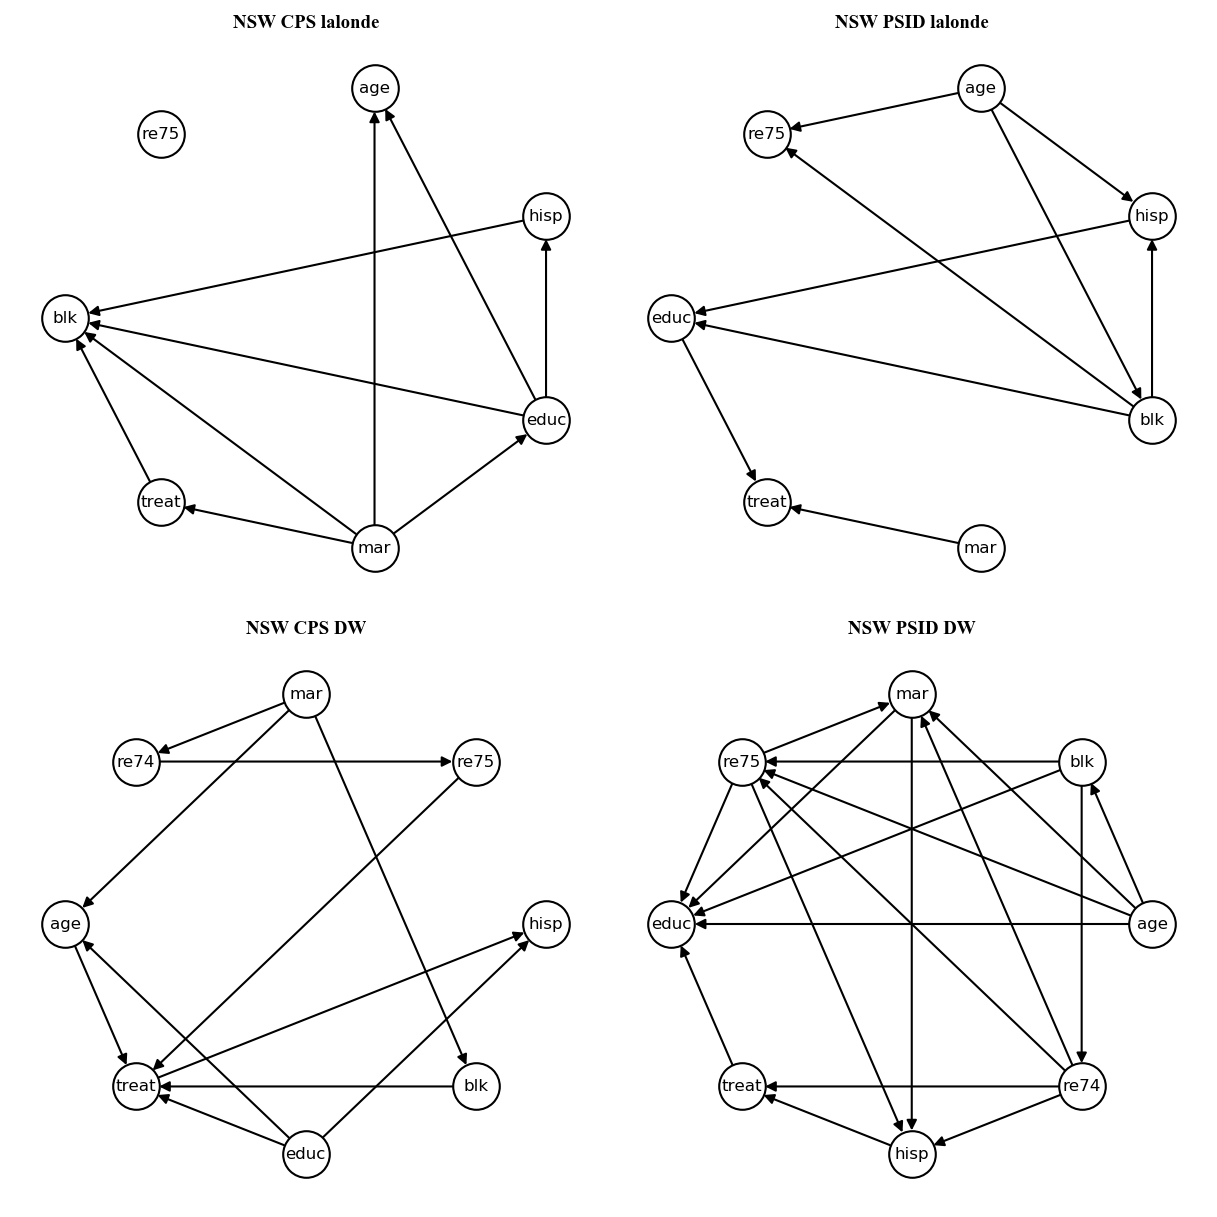

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (8,8))

plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax[0,0].title.set_text("NSW CPS lalonde")
ax[0,1].title.set_text("NSW PSID lalonde")
ax[1,0].title.set_text("NSW CPS DW")
ax[1,1].title.set_text("NSW PSID DW")

draw(dag1,ax[0,0])
draw(dag2,ax[0,1])
draw(dag3,ax[1,0])
draw(dag4,ax[1,1])


plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/plots/dags/nsw_cps_lalonde_dag_2_re78.png', bbox_inches='tight')

